In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
x = torch.empty(48,1,256,256)

In [ ]:
_x = x.permute(1,0,2,3).unsqueeze(0)
F.interpolate(_x,scale_factor=(1/2,1,1), mode="nearest").shape

In [ ]:
x.shape[0]*2,x.shape[1:]

In [ ]:
_shape = x.shape
torch.tensor([_shape[0]*2,*_shape[1:]])

In [ ]:
from monai.transforms import (
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    Lambda,
    LoadImaged,
    ResizeWithPadOrCrop,
    ScaleIntensityRangePercentilesd,
    SqueezeDim,
)
transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        ScaleIntensityRangePercentilesd(
            keys=["image"], lower=0.1, upper=99.9, b_min=0.0, b_max=1.0, clip=False
        ),
        # CropForegroundd(
        #     keys=["image", "mask"],
        #     source_key="mask",
        #     # margin=[0, 128, 128] if args.seq == "T1" else [128, 128, 0],
        #     allow_smaller=True,
        # ),
        Lambda(func=lambda x: x["image"]),
    ]
)

In [ ]:
transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRangePercentilesd(
            keys=["image"], lower=0.1, upper=99.9, b_min=0.0, b_max=1.0, clip=False
        ),
        Lambda(func=lambda x: x["image"]),
    ]
)
path = "/root/aicp-data/IXI_downsampledx2_iacl/IXI002-Guys-0828/T1.nii.gz"
mask_path = "/root/aicp-data/IXI_downsampledx2_iacl/IXI002-Guys-0828/T1_mask.nii.gz"
data = transforms({"image": path})

In [ ]:
data.shape

In [ ]:
import torch
torch.manual_seed(0)


def _A(x):
    # return radon.A(x)
    # return F.interpolate(
    #     x, scale_factor=factor, mode="nearest", align_corners=False
    # )
    indices = torch.arange(0, x.size(0), factor, device=x.device, dtype=torch.long)
    return x.index_select(0, indices)

def _AT(y):
    # y: [Nsamp, C, H, W] or general [...], factor from outer scope
    # target_shape = (y.shape[0] * factor, *y.shape[1:])  # tuple of ints, safe
    target_shape = img_shape
    x_hr = torch.zeros(target_shape, device=y.device, dtype=y.dtype)
    indices = torch.arange(
        0, target_shape[0], factor, device=y.device, dtype=torch.long
    )
    x_hr.index_copy_(0, indices, y)
    return x_hr

device = 'cuda'  # just keep device logic

img_shape = (179,1,256,256)
factor=2.0
# 随机 x, y 维度需与 A/AT 对应
x = torch.randn(img_shape, device='cuda' if torch.cuda.is_available() else 'cpu', dtype=torch.float32)
y = torch.randn((int(img_shape[0]//factor)+1, *img_shape[1:]), device=x.device, dtype=x.dtype)

Ax = _A(x)
ATy = _AT(y)

lhs = float((Ax.flatten() * y.flatten()).sum().cpu().numpy())
rhs = float((x.flatten() * ATy.flatten()).sum().cpu().numpy())
print("Adjoint test: <A x, y> =", lhs, ", <x, A^T y> =", rhs, ", diff =", abs(lhs-rhs))


In [ ]:
ones = torch.ones_like(x).to(x.device)
k = img_shape[0]//4
x0 = torch.zeros(img_shape, device=ones.device)
x0[k:k+1] = 1.0
y0 = _A(x0)
x0_back = _AT(y0)
nonzero_sums = x0_back.abs().sum(dim=(1,2,3))
nonzero_idx = (nonzero_sums > 1e-8).nonzero().squeeze().cpu().numpy()
print("nonzero slice indices in x0_back:", nonzero_idx)
print("nonzero sums values (selected):", nonzero_sums[nonzero_idx].cpu().numpy())

In [ ]:
k = img_shape[0]//4
x0 = torch.zeros(img_shape, device=ones.device)
x0[k:k+1] = 1.0
y0 = _A(x0)
x0_back = _AT(y0)
nonzero_sums = x0_back.abs().sum(dim=(1,2,3))
nonzero_idx = (nonzero_sums > 1e-8).nonzero().squeeze().cpu().numpy()
print("nonzero slice indices in x0_back:", nonzero_idx)
print("nonzero sums values (selected):", nonzero_sums[nonzero_idx].cpu().numpy())


In [ ]:
list(range(2))


In [ ]:
from pathlib import Path
p = Path(
    f"./results/a/b/M_iter{1}/K_iter{1}/rho{0.05}/lambda{0.1}/AncestralSamplingPredictor/N{50}_noFinalConsistency"
)
"_".join(p.parts[-6:])

In [ ]:
from models.ncsnpp import NCSNpp
from configs.ve.AAPM_256_ncsnpp_continuous import get_config
config = get_config()
model = NCSNpp(config)

In [ ]:

# 2025年9月30日
# 验证ncsnpp输入输出维度一致
import torch
y = model(torch.randn(2,1,256,256),time_cond=torch.tensor([0.1,0.2]))
print(y.shape)


In [1]:
# Load config
from ml_collections.config_flags import config_flags
from absl import flags
FLAGS = flags.FLAGS
config_flags.DEFINE_config_file(
  "config", "configs/ve/IXI_256_ncsnpp_continuous.py", "Training configuration.", lock_config=True)
# main
FLAGS([''])
config = FLAGS.config.data

In [9]:
# 2025年9月30日
# data pipeline 研究
# 1.基于monai GridPatch的pipeline工作流程
# 2.Ax、Sag、Cor方向对应的patch_size如何切片



import json
import os.path as osp

from monai.data import CacheDataset, GridPatchDataset, PatchIter, ShuffleBuffer
from monai.transforms import (
    Compose,
    EnsureChannelFirst,
    LoadImage,
    ResizeWithPadOrCrop,
    ScaleIntensityRangePercentiles,
    SqueezeDim,
)

train_val = "train"


patch_size = (1, None, None) if config.seq == "T1" else (None, None, 1)
assert train_val in ["train", "val"], "train_val must be 'train' or 'val'"
with open(config.json, "r") as f:
    datalist = json.load(f)
data_list = [osp.join(x.replace("/root/aicp-data/","../IXI_dataset/"), f"{config.seq}_gt.nii.gz") for x in datalist[train_val]]

transforms = Compose(
    [
        LoadImage(),
        EnsureChannelFirst(),
        ScaleIntensityRangePercentiles(
            lower=0.05, upper=99.9, b_min=0.0, b_max=1.0, clip=False
        ),
    ]
)
#load 2 volumes for testing
# ['/root/aicp-data/IXI_downsampledx2_iacl/IXI002-Guys-0828/T1_gt.nii.gz',
#  '/root/aicp-data/IXI_downsampledx2_iacl/IXI012-HH-1211/T1_gt.nii.gz']
volume_ds = CacheDataset(
    data=data_list[:2],
    transform=transforms,
    cache_rate=1.0,
    num_workers=1,
)

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


torch.Size([1, 256, 256, 173])


(-0.5, 255.5, 255.5, -0.5)

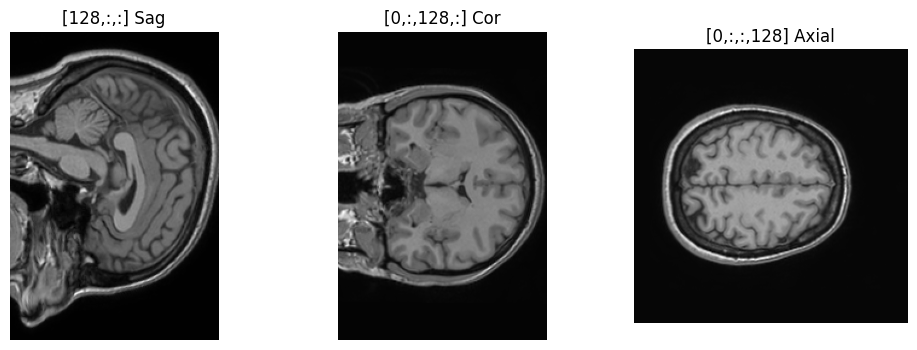

In [17]:
print(volume_ds[0].shape)
# visualization 以确定各维度方向
import matplotlib.pyplot as plt
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(volume_ds[0][0,128,:,:].squeeze(),cmap="gray")
plt.title(f"[128,:,:] Sag")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(volume_ds[0][0,:,128,:].squeeze(),cmap="gray")
plt.title(f"[0,:,128,:] Cor")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(volume_ds[0][0,:,:,128].squeeze(),cmap="gray")
plt.title(f"[0,:,:,128] Axial")
plt.axis("off")

In [2]:
print(config)

centered: false
dataset: IXI
image_size: 256
is_complex: false
is_multi: false
json: ../IXI_diffusion/dataset_split.json
num_channels: 1
orientation: AX
random_flip: true
root: /media/harry/tomo/AAPM_data/256
seq: T1
uniform_dequantization: false



In [22]:
# 关于shufflebuffer的小实验
import monai
from monai.data import DataLoader

# 自定义一个带 buffer 可视化的 ShuffleBuffer
class DebugShuffleBuffer(monai.data.ShuffleBuffer):
    def generate_item(self):
        """和原版一样，但在每次 yield 前打印 buffer"""
        buffer = []
        for item in iter(self.data):
            if len(buffer) >= self.size:
                _buffer = buffer.copy()
                val = self.randomized_pop(buffer)
                print(f"[generate_item] buffer={_buffer}, yield={val}")
                yield val
            buffer.append(item)
        while buffer:
            _buffer = buffer.copy()
            val = self.randomized_pop(buffer)
            print(f"[generate_item] buffer={_buffer}, yield={val}")
            yield val

# dataset = range(20)
dataset = DebugShuffleBuffer(data=range(20), buffer_size=5, seed=42, epochs=1)

# DataLoader
dataloader = DataLoader(dataset, batch_size=2, num_workers=0)

print("开始迭代 DataLoader：")
for i, batch in enumerate(dataloader):
    print(f"[dataloader] iteration {i}, batch={batch.tolist()}")
print("DataLoader 迭代结束")


开始迭代 DataLoader：
[generate_item] buffer=[0, 1, 2, 3, 4], yield=0
[generate_item] buffer=[4, 1, 2, 3, 5], yield=1
[dataloader] iteration 0, batch=[0, 1]
[generate_item] buffer=[4, 5, 2, 3, 6], yield=2
[generate_item] buffer=[4, 5, 6, 3, 7], yield=4
[dataloader] iteration 1, batch=[2, 4]
[generate_item] buffer=[7, 5, 6, 3, 8], yield=3
[generate_item] buffer=[7, 5, 6, 8, 9], yield=5
[dataloader] iteration 2, batch=[3, 5]
[generate_item] buffer=[7, 9, 6, 8, 10], yield=8
[generate_item] buffer=[7, 9, 6, 10, 11], yield=10
[dataloader] iteration 3, batch=[8, 10]
[generate_item] buffer=[7, 9, 6, 11, 12], yield=6
[generate_item] buffer=[7, 9, 12, 11, 13], yield=7
[dataloader] iteration 4, batch=[6, 7]
[generate_item] buffer=[13, 9, 12, 11, 14], yield=11
[generate_item] buffer=[13, 9, 12, 14, 15], yield=12
[dataloader] iteration 5, batch=[11, 12]
[generate_item] buffer=[13, 9, 15, 14, 16], yield=14
[generate_item] buffer=[13, 9, 15, 16, 17], yield=16
[dataloader] iteration 6, batch=[14, 16]
[gen